# Exploring photon heights with ICESat-2 (ATL03)

Information obtained primarily from the ATL03 Algorithm Theoretical Basis Document (ATBD, Neumann et al., 2019) and the NSIDC product description page: https://nsidc.org/data/atl03.   

* Notebook author: Ellen Buckley, heavily based on 2019 Hackweek notebook by Alek Petty, and relying extensively on the ATBD and product description.   
* Description: Notebook describing the ICESat-2 ATL03 product.   
* Input requirements: The demo ATL03 input file 'ATL03_20190206123200_06120204_002_01.h5'
* Date: June 2020
* More info: at NSIDC https://nsidc.org/data/atl03 under the Technical References tab you'll see:
    - Algorithm Theoretical Basis Document (ATBD)
    - known issues document
    - data dictionary

## Notebook objectives
* General understanding of the data included in a typical ATL03 file.
* Reading in, plotting and basic analysis of ATL03 data.
* Understanding along-track distance and time variables.
* Understanding of differences between weak and strong beams


In [5]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import h5py  
from astropy.time import Time
import readers as rd

## Select and Import Data

#### Granule Selection

ATL03 data are separated into granules that make up 1/14th of an orbit, so there are 14 regions. The Arctic regions are 03, 04, and 05.

region 03: 59.5° N → 80° N (ascending)

region 04: 80° N (ascending) → 80° N (descending)

region 05: 80° N → 59.5° N (descending)

Image showing ATL03 polar regions: credit Tyler Sutterly, github.com/tsutterley/

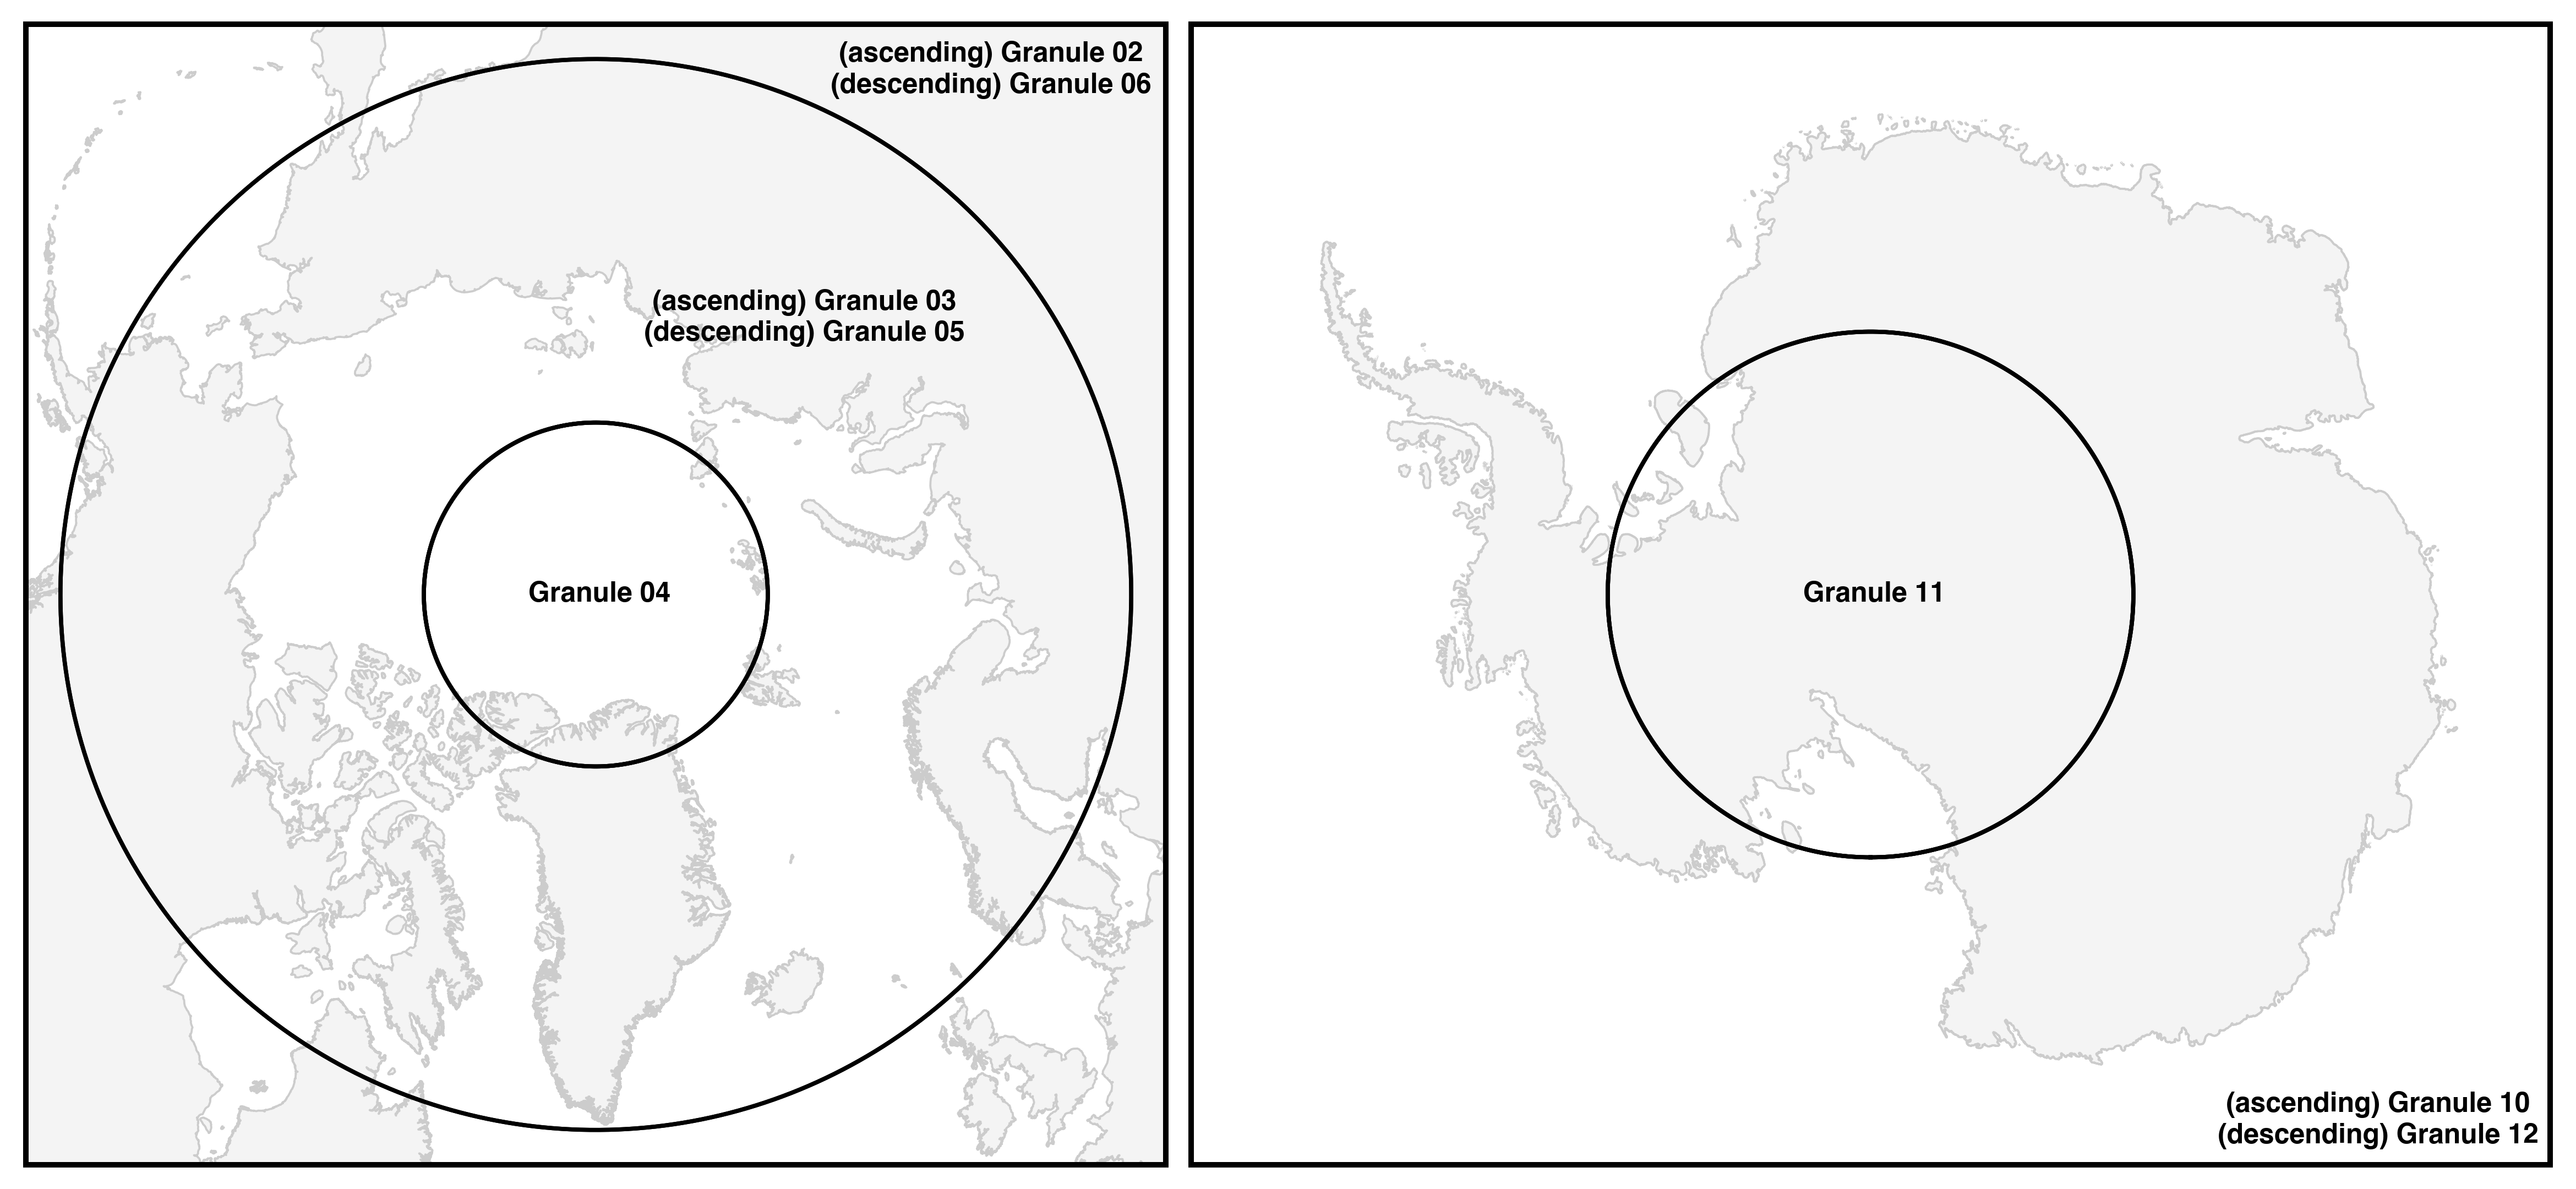

We will work with one granule from region 04 in this notebook, which we will grab it from the tutorial-data/sea-ice/ folder:

ATL03_20190206123200_06120204_002_01.h5


#### Import Data

In [6]:
data_loc='/home/jovyan/tutorial-data/sea-ice/'
fname='ATL03_20190206123200_06120204_002_01.h5'

In [7]:
f = h5py.File(data_loc+fname, 'r')
# check to see if it is forward (1)  or backward (0) orientation to know which beam is strong/weak. 
# (2 is transition phase- don't use these data)
print(f['orbit_info/sc_orient'][0])


0


in backward orientation, left beams are strong, right are weak. Lets choose the gt1l, a strong beam. Now we bring in basic parameters and store into a pandas dataframe.


In [8]:
beam='gt1l'
df03=rd.getATL03(f,beam)
df03.head()

,lats,lons,x,y,heights,dt,conf
0,79.990105,-48.420387,8938429.0,5144.789062,1988.997803,3.469152e+07,-1
1,79.990104,-48.420387,8938429.0,5144.785645,1989.362915,3.469152e+07,-1
2,79.990104,-48.420387,8938429.0,5144.787109,1989.231079,3.469152e+07,-1
3,79.990104,-48.420387,8938429.0,5144.785645,1989.333374,3.469152e+07,-1
4,79.990105,-48.420389,8938429.0,5144.824219,1985.447388,3.469152e+07,-1


## Map data

Here we are using the Python module cartopy to map the data. Because ATL03 granules contain A LOT of data, we can subset the data and take every 1000th point to get an idea of where the data are and what the variables look like.

#### Map the data to see location

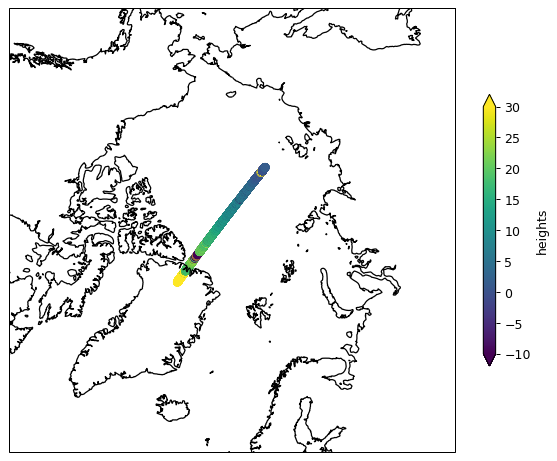

In [9]:
var= 'heights' #choose which variable we want to plot

## we will want to set colorbar parameters based on the chosen variable
vmin=-10
vmax=30
ticks=np.arange(-20,100,5)


plt.figure(figsize=(8,8), dpi= 90)
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0)) # choose polar sterographic for projection
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
plt.scatter(df03['lons'][::1000], df03['lats'][::1000],c=df03[var][::1000], cmap='viridis', vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())
plt.colorbar(label=var, shrink=0.5, ticks=ticks,extend='both')

## Plot a closer look at the data

Here we are subsetting the data based on a region of interest. We have to convert the time variable from gps seconds to UTC, which is more recognizeable and convenient to work with. We will plot height v. time and height v. alongtrack distance. 

### Closer look at section

In [10]:
## create bounding box of interest:
lonmin,lonmax,latmin,latmax= [-90,-30,86,86.1]

bbox=(df03['lons']>lonmin)&(df03['lons']<lonmax)&(df03['lats']>latmin)&(df03['lats']<latmax)
df_cut=df03[bbox]

## converting GPS time to UTC time
epoch=f['/ancillary_data/atlas_sdp_gps_epoch'][0]
df_cut['time']=Time(epoch+df_cut['dt'],format='gps').utc.datetime

## calculate along track distance relative to the beginning of the cut segment
df_cut['AT_dist']=df_cut.x-df_cut.x.values[0]

df_cut.head()

,lats,lons,x,y,heights,dt,conf,time,AT_dist
7112727,86.000002,-67.839525,9650440.0,5418.188477,19.335434,3.469162e+07,4,2019-02-06 12:33:39.790575,0.0
7112728,86.000002,-67.839526,9650440.0,5418.190430,19.146452,3.469162e+07,4,2019-02-06 12:33:39.790575,0.0
7112729,86.000002,-67.839526,9650440.0,5418.191406,19.043926,3.469162e+07,4,2019-02-06 12:33:39.790575,0.0
7112730,86.000002,-67.839526,9650440.0,5418.189453,19.220772,3.469162e+07,4,2019-02-06 12:33:39.790575,0.0
7112731,86.000002,-67.839525,9650440.0,5418.186523,19.497667,3.469162e+07,4,2019-02-06 12:33:39.790575,0.0


Height v. Time plot

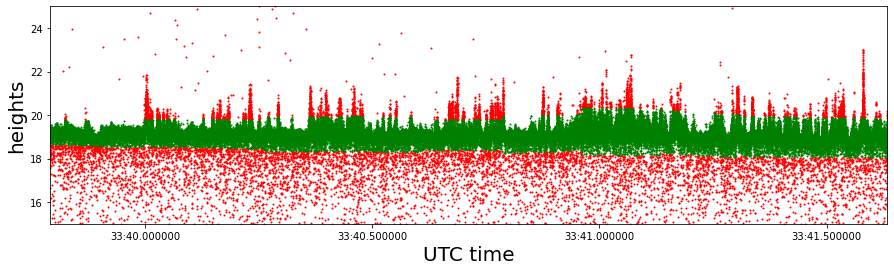

In [11]:
plt.subplots(1,1,figsize=(15,4))
plt.scatter(df_cut.time.values[df_cut.conf<3],df_cut.heights.values[df_cut.conf<3],c='r',s=1)
plt.scatter(df_cut.time.values[df_cut.conf>2],df_cut.heights.values[df_cut.conf>2],c='g',s=1)
plt.xlabel('UTC time',fontsize=20)
plt.ylabel('heights',fontsize=20)
plt.ylim(15,25);
plt.xlim(df_cut.time.values[0],df_cut.time.values[-1]);

Height v. along track distance plot

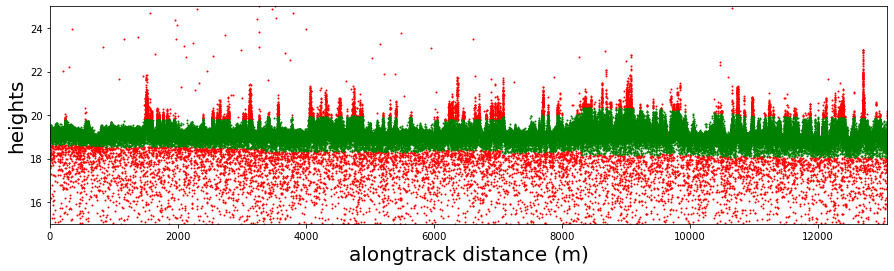

In [12]:
plt.subplots(1,1,figsize=(15,4))
plt.scatter(df_cut.AT_dist.values[df_cut.conf<3],df_cut.heights.values[df_cut.conf<3],c='r',s=1)
plt.scatter(df_cut.AT_dist.values[df_cut.conf>2],df_cut.heights.values[df_cut.conf>2],c='g',s=1)
plt.xlabel('alongtrack distance (m)',fontsize=20)
plt.ylabel('heights',fontsize=20)
plt.ylim(15,25);
#plt.ticklabel_format(style="plain",axis="x", useOffset=False)
plt.xlim(df_cut.AT_dist.values[0],df_cut.AT_dist.values[-1]);

Let's look at just 1 km of data

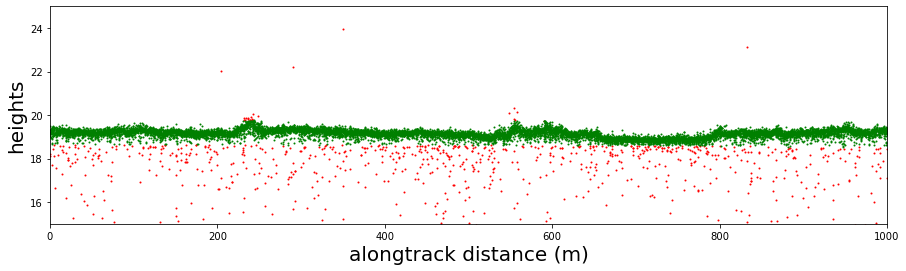

In [13]:
plt.subplots(1,1,figsize=(15,4))
plt.scatter(df_cut.AT_dist.values[df_cut.conf<3],df_cut.heights.values[df_cut.conf<3],c='r',s=1)
plt.scatter(df_cut.AT_dist.values[df_cut.conf>2],df_cut.heights.values[df_cut.conf>2],c='g',s=1)
plt.xlabel('alongtrack distance (m)',fontsize=20)
plt.ylabel('heights',fontsize=20)
plt.ylim(15,25);
plt.xlim(df_cut.AT_dist.values[0],1000);

Here we can see the high confidence surface photons in green. The background photons (red) that appear below the surface are from subsurface scattering, delaying the return of photons to the receiver. Note that if we were looking at summer data there would be more background photons above the surface due to the solar background.

### Look at strong beam v. weak beam

In [14]:
# pull in weak beam, combining bounding box, time conversion, alongtrack distance calculation.
beam='gt1r'
df03_w=rd.getATL03(f,beam)

lonmin,lonmax,latmin,latmax= [-90,-30,86,86.1]
bbox=(df03_w.lons>lonmin)&(df03_w.lons<lonmax)&(df03_w.lats>latmin)&(df03_w.lats<latmax)
df_cut_w=df03_w[bbox]

## converting time
df_cut_w['time']=Time(epoch+df_cut_w['dt'],format='gps').utc.datetime
## relative alongtrack distance
df_cut_w['AT_dist']=df_cut_w.x-df_cut_w.x.values[0]

df_cut_w.head()

,lats,lons,x,y,heights,dt,conf,time,AT_dist
1708111,86.000002,-67.828278,9650395.0,5343.020996,19.301861,3.469162e+07,4,2019-02-06 12:33:40.130075,0.0
1708112,86.000002,-67.828278,9650395.0,5343.020508,19.333200,3.469162e+07,4,2019-02-06 12:33:40.130075,0.0
1708113,86.000002,-67.828278,9650395.0,5343.020996,19.291342,3.469162e+07,4,2019-02-06 12:33:40.130075,0.0
1708114,86.000002,-67.828278,9650395.0,5343.021484,19.254053,3.469162e+07,4,2019-02-06 12:33:40.130075,0.0
1708115,86.000007,-67.828325,9650396.0,5343.018555,19.430183,3.469162e+07,4,2019-02-06 12:33:40.130175,1.0


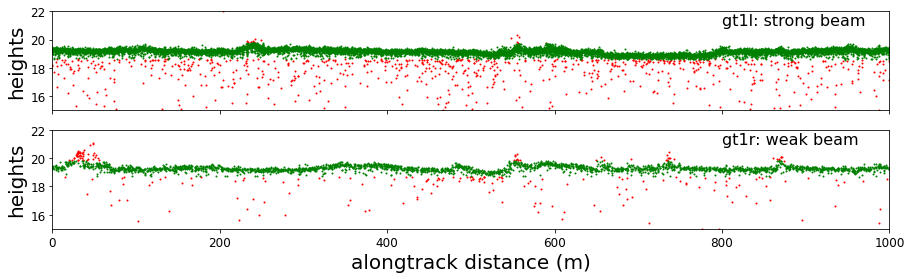

In [15]:
fig,ax=plt.subplots(2,1,figsize=(15,4), sharex=True)

ax[0].scatter(df_cut.AT_dist.values[df_cut.conf==1],df_cut.heights.values[df_cut.conf==1],c='r',s=1)
ax[0].scatter(df_cut.AT_dist.values[df_cut.conf==2],df_cut.heights.values[df_cut.conf==2],c='orange',s=1)
ax[0].scatter(df_cut.AT_dist.values[df_cut.conf==3],df_cut.heights.values[df_cut.conf==3],c='g',s=1)
ax[0].scatter(df_cut.AT_dist.values[df_cut.conf==4],df_cut.heights.values[df_cut.conf==4],c='g',s=1)
ax[0].set_ylabel('heights',fontsize=20)
ax[0].tick_params(labelsize=12)
ax[0].set_ylim(15,22);
ax[0].text(800,21,'gt1l: strong beam',fontsize=16)


ax[1].scatter(df_cut_w.AT_dist.values[df_cut_w.conf==1],df_cut_w.heights.values[df_cut_w.conf==1],c='r',s=1)
ax[1].scatter(df_cut_w.AT_dist.values[df_cut_w.conf==2],df_cut_w.heights.values[df_cut_w.conf==2],c='orange',s=1)
ax[1].scatter(df_cut_w.AT_dist.values[df_cut_w.conf==3],df_cut_w.heights.values[df_cut_w.conf==3],c='g',s=1)
ax[1].scatter(df_cut_w.AT_dist.values[df_cut_w.conf==4],df_cut_w.heights.values[df_cut_w.conf==4],c='g',s=1)
ax[1].set_ylabel('heights',fontsize=20)
ax[1].tick_params(labelsize=12)
ax[1].set_ylim(15,22);
ax[1].text(800,21,'gt1r: weak beam',fontsize=16)

plt.xlabel('alongtrack distance (m)',fontsize=20)
plt.xlim(df_cut.AT_dist.values[0],1000);

Notice fewer returns from the weak beam. The energy ratio between the weak and strong beams is approximately 1:4 and are separated by 90 m in the across-track direction. 